# 1. Importing and Cleaning Data

In [ ]:
import pandas as pd
import numpy as np
import csv
import seaborn as sns
import matplotlib.pyplot as plt         

Loading the files

In [ ]:
# Load the CSV file
csv_file_path = '/Users/gregorycrooks/Downloads/pitch_by_pitch_metadata 2.csv'
csv_data = pd.read_csv(csv_file_path, encoding='latin-1')

# Display the first few rows of the CSV to understand its structure
print(csv_data.head())

# Load the text file
text_file_path = '/Users/gregorycrooks/Downloads/pitches_folder/pitches'
with open(text_file_path, 'r') as file:
    text_data = file.readlines()

### Cleaning up the Data

In [ ]:
import pandas as pd
import random

# Assuming text_data contains both the header and the values
# The first row is the header, and the rest are the data
header = text_data[0]
data = text_data[1:]  # Exclude the header

# Randomly sample 200,000 rows from the data
random_sample = random.sample(data, 50000)

# Split the header by commas and remove double quotes
header = [col.replace('"', '') for col in header.split(",")]

# Create an empty list to hold valid rows
valid_rows = []

# Loop through each sampled row
for i in random_sample:
    # Split each row by commas and remove double quotes from each value
    row = [val.replace('"', '') for val in i.split(",")]
    
    # Check for different row lengths
    if len(row) == 126:
        # If the length is 126, find and pop one value
        consecutive_empty_count = 0
        for index in range(len(row)):
            if row[index] == "":
                consecutive_empty_count += 1
                if consecutive_empty_count == 2:
                    # Pop one empty value
                    row.pop(index)
                    break  # Break after removing one value
            else:
                consecutive_empty_count = 0  # Reset if a non-empty value is found

    elif len(row) == 127:
        # If the length is 127, find and pop two values
        consecutive_empty_count = 0
        for index in range(len(row)):
            if row[index] == "":
                consecutive_empty_count += 1
                if consecutive_empty_count == 2:
                    # Pop two consecutive values
                    del row[index-1:index+1]  # Remove two consecutive values starting from index-1
                    break  # Break after removing two values
            else:
                consecutive_empty_count = 0  # Reset if a non-empty value is found

    # If the length is 125, do nothing (just append the row)
    if len(row) == 125:
        valid_rows.append(row)

# Create a DataFrame using the valid rows and adjust the header if needed
df = pd.DataFrame(valid_rows, columns=header[:len(valid_rows[0])])

# Display or further process the DataFrame
df


# 2. EDA

Dropping irrelevant columns

In [ ]:
df.columns

In [ ]:
df = df.drop(df.columns[72:125], axis=1)


In [ ]:
df.tail(5)

Duplicated rows: we find none

In [ ]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

Types for columns:

In [ ]:
df.dtypes.value_counts()

Null percentage:

In [ ]:

# Replace empty strings with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

# Calculate the percentage of NaN values in each column
#n = (df.isnull().sum() / len(df)) * 100

# Get columns with 100% NaN values
#n

Let's remove additional columns:

In [ ]:
df = df.drop(columns=['date','pitch_tfs', 'start_tfs', 'start_tfs_zulu'])

In [ ]:
df.columns

In [ ]:
df.start_speed

Detect outliers for start_speed

In [ ]:
sns.boxplot(x=df['start_speed'].astype(float))
print(df['start_speed'].astype(float).max())

Detect outlier for end speed

In [ ]:
sns.boxplot(x=df['end_speed'].astype(float))
print(df['end_speed'].astype(float).max())

Outlier for batter_height

In [ ]:
df['b_height'] = df['b_height'].replace('-', '.', regex=True)

sns.boxplot(x=df['b_height'].astype(float))

Column types

In [ ]:
df.dtypes

Convert columns to relevant type 

In [ ]:
# List of categorical columns
df_cat = ['uid', 'game_pk', 'team_id_b', 'team_id_p', 'pitcher_id', 
          'batter_id', 'event', 'event2', 'event3', 'event4', 'pitch_type', 'zone', 'pitch_id', 'pitch_des', 'is_final_pitch',
          'on_1b', 'on_2b', 'on_3b', 'type', 'at_bat_des','sv_id']
# Convert categorical columns to object type
df[df_cat] = df[df_cat].astype('object')

# Apply numeric conversion to all other columns except the categorical columns
for column in df.columns:
    if column not in df_cat:
        df[column] = pd.to_numeric(df[column], errors='coerce')


Let's double check numeric columns and identify potential categorical columns added:

In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df.select_dtypes(include=numerics).head()

Year is only 2011. It might've been interesting to do a Drift Analysis if there were other years, which is no the case:

In [ ]:
df = df.drop(columns=['year'])

cc has a very high count of nulls; let's remove that columns

In [ ]:
print(df.cc.isna().sum())
df = df.drop(columns=['cc'])

In [ ]:
pd.set_option('display.max_columns', 20)

This leaves us with 45 numerical columns and 21 categorical columns:

In [ ]:
num_columns = df.select_dtypes(include=numerics).count()
cat_columns = df.select_dtypes(include=object).count()

print(len(num_columns), len(cat_columns))

Interquartile range

In [ ]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
IQR

Remove outliers

In [ ]:
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
sns.boxplot(x=df['start_speed'].astype(float))


Pitch Types

In [ ]:
df['pitch_type'].value_counts()

Removing bad pitch type

In [ ]:
df = df[~df['pitch_type'].apply(lambda x: isinstance(x, (int, float)))]
df = df[pd.to_numeric(df['pitch_type'], errors='coerce').isna()]
df = df.reset_index(drop=True)
df['pitch_type'].value_counts()


Rename the pitch types - We find imbalances in the pitch type counts; bias for the model

In [ ]:
# Dictionary mapping pitch types, combining Fastballs and Curveballs
pitch_type_combined_mapping = {
    'CH': 'Changeup',
    'CU': 'Curveball',
    'FC': 'Cutter',
    'EP': 'Eephus',
    'FO': 'Forkball',
    'FT': 'Fastball',  # Combine Two-Seam Fastball
    'FA': 'Fastball',  # Combine Two-Seam Fastball
    'FF': 'Fastball',  # Combine Four-Seam Fastball
    'KN': 'Knuckleball',
    'KC': 'Curveball',  # Combine Knuckle-Curve into Curveball
    'PO': 'Pitcher Only',
    'SC': 'Screwball',
    'SI': 'Sinker',
    'SL': 'Slider',
    'SV': 'Slurve',
    'FS': 'Splitter',
    'ST': 'Sweeper'
}

# Replace the pitch types in the 'pitch_type' column with combined categories
df['pitch_type'] = df['pitch_type'].replace(pitch_type_combined_mapping)

# Display the updated value counts to verify the changes
print(df['pitch_type'].value_counts())


Number of observations

In [ ]:
df.shape

Remove the ones with little to no observations - find data for the edge cases; or do bayesian model for these pitch types

In [ ]:
df = df[~df['pitch_type'].isin(["Forkball", "IN", "Pitcher Only", "Screwball", "Eephus", "UN", "AB"])]
df['pitch_type'].value_counts()


Describe numerical features

In [ ]:
df.describe()

Is final pitch a parameter to determine the pitch type? - 24% of the pitches are final pitches

In [ ]:
# In all t
df.is_final_pitch.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

Pitch all have a similar proportion of final pitches - little significance in differentiating the pitches 

In [ ]:
df.is_final_pitch = df.is_final_pitch.replace({'0': "No", '1': "Yes"})
# Group by 'pitch_type' and 'is_final_pitch', and count the occurrences
grouped_data = df.groupby(['pitch_type', 'is_final_pitch']).size().reset_index(name='pitch_count')

# Calculate the total count for each 'pitch_type'
grouped_data['total_count'] = grouped_data.groupby('pitch_type')['pitch_count'].transform('sum')

# Calculate the percentage for each group within the 'pitch_type'
grouped_data['percentage'] = (grouped_data['pitch_count'] / grouped_data['total_count']) * 100

# Create a Seaborn plot
plt.figure(figsize=(20, 6))  # Set the figure size
sns.barplot(x='pitch_type', y='percentage', hue='is_final_pitch', data=grouped_data)

plt.title('Percentage of Final Pitches by Pitch Type')
plt.ylabel('% of Final Pitches')
plt.xlabel('Pitch Type')
plt.legend(title='Is Final Pitch')
plt.show()


Histogram start_speed - Showing left Skewdness and unimodal distribution; which might have to be transformed in pre-processing steps of our model

In [ ]:
sns.histplot(data=df, x="start_speed", bins=30, kde=True)

Histograms for Start_speed for Four-Seam Fastball vs Two-Seam Fastball pitch types - they distribution tends to be more normal than the overall data's start speed, with still a mild left skewdness

In [ ]:
sns.histplot(data=df[df["pitch_type"] == "Four-Seam Fastball"], x="start_speed", bins=30, kde=True)

In [ ]:
sns.histplot(data=df[df["pitch_type"] == "Two-Seam Fastball"], x="start_speed", bins=30, kde=True)

Let's look at the start speed description across data

In [ ]:
df.start_speed.describe()

Comparing the start speed numerical descriptions with certain pitch types - Four-Seam Fastball start speed mean and median are higher than the data's, and more clustered around the mean

In [ ]:
df[df["pitch_type"] == "Four-Seam Fastball"].start_speed.describe()

The curveball pitch types have an average start speed 10 mph slower than the data mean. They are also more clustered around the mean

In [ ]:
df[df["pitch_type"] == "Curveball"].start_speed.describe()

Let's create boxplots for each speed type, and one for the entire data - overall, the speed type will be good in determining the type of pitch. We see that the start speed strongly varies according to the pitch type. Four Seam Fastball type seems to indicate a vast amount of outliers, especially lower bound.

In [ ]:
import plotly.graph_objects as go
# get median start_speed 
median_speed = df.groupby('pitch_type')['start_speed'].median()

sorted_pitch_types = median_speed.sort_values(ascending = False).index

box_plots = []

# ADD BOXPLOT FOR ALL DATA
box_plots.append(
  go.Box(
    y = df['start_speed'],
    name = 'All Data',
    boxpoints = 'outliers',
    marker = dict(color = 'grey'),
    opacity = 0.5
  )
)
    
for pitch_type in sorted_pitch_types:
  box_plots.append(
    go.Box(
      y = df[df['pitch_type'] == pitch_type]['start_speed'],
      name = pitch_type,
      boxpoints = 'outliers',
      #jitter = 0.3,
      #pointpos = -1.8
    )
)
 
fig = go.Figure(data = box_plots)

fig.update_layout(
  title = "Box plots of start speed by pitch type",
  xaxis_title = "Pitch Type",
  yaxis_title = "Start Speed",
  xaxis = dict(tickangle = 45),
  #boxmode = "group"
)

fig.show()

Multimodality - Are there differences on whether it is the final pitch or not? - We find little modality with regards to the final pitch

In [ ]:
plt.figure(figsize=(20, 10))
# Create a grouped boxplot comparing start_speed across different pitch types
sns.boxplot(x='pitch_type', y='start_speed', hue= df.is_final_pitch,data=df)
# Overlay a separate boxplot for the overall data
# Add titles and labels
plt.title('Start Speed by Pitch Type and Overall')
plt.xlabel('Pitch Type / Overall')
plt.ylabel('Start Speed (mph)')

plt.show()
print("Count of Forkball is", df[df['pitch_type'] == "Forkball"].count().max())

Batter Height and Pitch Type -  Batter's most frequent height is around 6.2 feet

In [ ]:
counts = df.groupby('b_height').size()
unique_b_height = df.b_height.nunique()

# Step 2: Plot histogram based on the counts
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="b_height", bins=unique_b_height)
# Add labels and title
plt.title('Histogram of Counts by B_Height')
plt.xlabel('B_Height')
plt.ylabel('Count')

# Show the plot
plt.show()

In [ ]:
df.pitch_type.unique()

We find the same distribution for the Changeup pitch type

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'pitch_type'
grouped = df.groupby('pitch_type')

# Create a figure with 3 columns and 4 rows to accommodate 10 pitch types
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 24))

# Flatten the axes array to easily iterate over it
axes = axes.flatten()

# Loop through each pitch type and corresponding axis to plot histograms
for (pitch_type, group), ax in zip(grouped, axes):
    # Count the unique heights for binning purposes
    unique_b_height = group['b_height'].nunique()
    
    # Plot histogram for each pitch type
    sns.histplot(data=group, x='b_height', bins=unique_b_height, ax=ax)
    
    # Add labels and title for each subplot
    ax.set_title(f'B_Height for {pitch_type}')
    ax.set_xlabel('B_Height')
    ax.set_ylabel('Count')

# Remove any empty subplots
for i in range(len(grouped), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


Let's see if Curveballs show the same distribution

In [ ]:
changeup_counts = df[df['pitch_type'] == "Curveball"].groupby('b_height').size()

# Step 2: Plot histogram based on the counts
plt.figure(figsize=(8, 6))
changeup_counts.plot(kind='bar', color='skyblue')

# Add labels and title
plt.title('Histogram of Curveball Counts by B_Height')
plt.xlabel('B_Height')
plt.ylabel('Count')

# Show the plot
plt.show()

Height seems to have little variation between pitch types

In [ ]:
changeup_counts = df[df['pitch_type'] == "Knuckleball"].groupby('b_height').size()

# Step 2: Plot histogram based on the counts
plt.figure(figsize=(8, 6))
changeup_counts.plot(kind='bar', color='skyblue')

# Add labels and title
plt.title('Histogram of Curveball Counts by B_Height')
plt.xlabel('B_Height')
plt.ylabel('Count')

# Show the plot
plt.show()

Top half of inning and pitch types

In [ ]:
df.top = df.top.replace({0: "No", 1: "Yes"})
df.top.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

Are some pitch types more frequent in the top of bottom half of inning, when comparing to the overall data ? Mild difference with fastballs more frequent in top inning

In [ ]:
df[df["pitch_type"] == "Sinker"].top.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

In [ ]:
df[df["pitch_type"] == "Two-Seam Fastball"].top.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

In [ ]:
df[df["pitch_type"] == "Four-Seam Fastball"].top.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

What about the end speed comparison between pitch_types? - The mean end speed is 81mph, with a range of values between 65 to 94mph

In [ ]:
df.end_speed.describe()

End speed strongly varies according to pitch types, with the median speed as a good indicator to determine the type. Although the patterns of the boxplots are strongly similar with start_speed.

In [ ]:
# get median end_speed 
median_speed = df.groupby('pitch_type')['end_speed'].median()

sorted_pitch_types = median_speed.sort_values(ascending = False).index

box_plots = []

# ADD BOXPLOT FOR ALL DATA
box_plots.append(
  go.Box(
    y = df['end_speed'],
    name = 'All Data',
    boxpoints = 'outliers',
    marker = dict(color = 'grey'),
    opacity = 0.5
  )
)
    
for pitch_type in sorted_pitch_types:
  box_plots.append(
    go.Box(
      y = df[df['pitch_type'] == pitch_type]['end_speed'],
      name = pitch_type,
      boxpoints = 'outliers',
      #jitter = 0.3,
      #pointpos = -1.8
    )
)
 
fig = go.Figure(data = box_plots)

fig.update_layout(
  title = "Box plots of end speed by pitch type",
  xaxis_title = "Pitch Type",
  yaxis_title = "End Speed",
  xaxis = dict(tickangle = 45),
  #boxmode = "group"
)

fig.show()

Let's see if these two variables are correlated - we find an extremely strong positive correlation which highlights collinearity. This means that we can remove one of these two variables for the model implementation without losing much interpretability

In [ ]:
df_speed = df.loc[:,["end_speed", 'start_speed']]
df_speed.corr()

Is speed highly correlated with other variables? - vy0 shows an extremely high correlation to both speeds. This also indicates collinearity

In [ ]:
# Sample data loading (assuming 'df' is already loaded)
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Select correlations related to 'sz_bot' and filter for high correlations
high_correlations = correlation_matrix['start_speed'][correlation_matrix['start_speed'].abs() > 0.6]

# Print the high correlation values
print("High Correlations with start_speed:")
print(high_correlations)

# Create a new DataFrame for the heatmap that only includes features with high correlations
high_corr_features = high_correlations.index.tolist()
high_corr_matrix = df[high_corr_features].corr()

# Visualization using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(high_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", center=0)
plt.title('High Correlation Matrix with Heatmap for start_speed')
plt.show()

Break by pitch type - finding whether there is a circular motion. There are 3 break columns:

In [ ]:
df_break_pitch_type = df.loc[:, ["break_length","break_angle", "pitch_type"]]
df_break_pitch_type

Fastballs will be faster with little curvature; shorter break length than other pitch types. A higher curve will indicate a longer break length. This helps indicate the different types of pitches

In [ ]:
df_break_pitch_type.groupby(["pitch_type"]).mean()

We find little to no relationship between break angle and the break length

In [ ]:
df_break_pitch_type.corr()

Comparing break angle: we find more variability in relation to the overall data with the: Knuckelball, Cutter, Slider, Curveball, Knuckle-Curve. The median of the first 5 derive less from the overall data median. This shows that the Break Angle variable will be good for model implementation.

In [ ]:
# get median end_speed 
median_speed = df.groupby('pitch_type')['break_angle'].median()

sorted_pitch_types = median_speed.sort_values(ascending = False).index

box_plots = []

# ADD BOXPLOT FOR ALL DATA
box_plots.append(
  go.Box(
    y = df['break_angle'],
    name = 'All Data',
    boxpoints = 'outliers',
    marker = dict(color = 'grey'),
    opacity = 0.5
  )
)
    
for pitch_type in sorted_pitch_types:
  box_plots.append(
    go.Box(
      y = df[df['pitch_type'] == pitch_type]['break_angle'],
      name = pitch_type,
      boxpoints = 'outliers',
      #jitter = 0.3,
      #pointpos = -1.8
    )
)
 
fig = go.Figure(data = box_plots)

fig.update_layout(
  title = "Box plots of Break Angle by pitch type",
  xaxis_title = "Pitch Type",
  yaxis_title = "Break Angle",
  xaxis = dict(tickangle = 45),
  #boxmode = "group"
)

fig.show()

For break length, we find a higher variability across pitch types in relation to the dataset. This shows to be an even better feature than the Break Angle, since most pitch types vary from each other as well as the overall data.

In [ ]:
# get median end_speed 
median_speed = df.groupby('pitch_type')['break_length'].median()

sorted_pitch_types = median_speed.sort_values(ascending = False).index

box_plots = []

# ADD BOXPLOT FOR ALL DATA
box_plots.append(
  go.Box(
    y = df['break_length'],
    name = 'All Data',
    boxpoints = 'outliers',
    marker = dict(color = 'grey'),
    opacity = 0.5
  )
)
    
for pitch_type in sorted_pitch_types:
  box_plots.append(
    go.Box(
      y = df[df['pitch_type'] == pitch_type]['break_length'],
      name = pitch_type,
      boxpoints = 'outliers',
      #jitter = 0.3,
      #pointpos = -1.8
    )
)
 
fig = go.Figure(data = box_plots)

fig.update_layout(
  title = "Box plots of Break Length by pitch type",
  xaxis_title = "Pitch Type",
  yaxis_title = "Break Length",
  xaxis = dict(tickangle = 45),
  #boxmode = "group"
)

fig.show()

Let's look at geospatial variables

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
# Get all unique pitch types
pitch_types = df['pitch_type'].unique()

# Add overall data as the first trace
fig.add_trace(go.Box(y=df['sz_bot'], name='Overall'))

# Add traces for each pitch type
for pitch in pitch_types:
    fig.add_trace(go.Box(y=df[df["pitch_type"] == pitch]['sz_bot'], name=pitch))

# Update layout to show legend
fig.update_layout(
    title="sz_bot by Pitch Type",
    yaxis_title="sz_bot",
    showlegend=True
)

# Show the figure
fig.show()

Find correlation between features and sz_bot:

In [ ]:
# Sample data loading (assuming 'df' is already loaded)
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Select correlations related to 'sz_bot' and filter for high correlations
high_correlations = correlation_matrix['sz_bot'][correlation_matrix['sz_bot'].abs() > 0.6]

# Print the high correlation values
print("High Correlations with sz_bot:")
print(high_correlations)

# Create a new DataFrame for the heatmap that only includes features with high correlations
high_corr_features = high_correlations.index.tolist()
high_corr_matrix = df[high_corr_features].corr()

# Visualization using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(high_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", center=0)
plt.title('High Correlation Matrix with Heatmap for sz_bot')
plt.show()

Does this also suggest low interpretability for pitch type for sz_top?

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
# Get all unique pitch types
pitch_types = df['pitch_type'].unique()

# Add overall data as the first trace
fig.add_trace(go.Box(y=df['sz_top'], name='Overall'))

# Add traces for each pitch type
for pitch in pitch_types:
    fig.add_trace(go.Box(y=df[df["pitch_type"] == pitch]['sz_top'], name=pitch))

# Update layout to show legend
fig.update_layout(
    title="sz_top by Pitch Type",
    yaxis_title="sz_top",
    showlegend=True
)

# Show the figure
fig.show()

# New EDA

Group by pitcher id - find; cluster pitcher

While these provide good overall information, the speed/curve variables contain information about the target variable which might are misleading - properties of the current pitch. This implicates non independence, likely create bias and multicollinearity when creating the model; breaking the indepedent assumption about X to y relationship

Features to average:
- Start_speed
- Spin rate
- Break_angle
- Break length

In [157]:
average_start_speed_pitcher = df.groupby("pitcher_id")['start_speed'].mean().reset_index()
average_break_angle_pitcher = df.groupby("pitcher_id")['break_angle'].mean().reset_index()
average_break_length_pitcher = df.groupby("pitcher_id")['break_length'].mean().reset_index()
average_spin_rate_pitcher = df.groupby("pitcher_id")['spin_rate'].mean().reset_index()


Histogram of the different pitcher measure distribution

<AxesSubplot:ylabel='Count'>

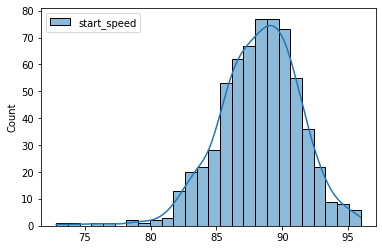

In [158]:
sns.histplot(data=average_start_speed_pitcher, kde=True)


<AxesSubplot:ylabel='Count'>

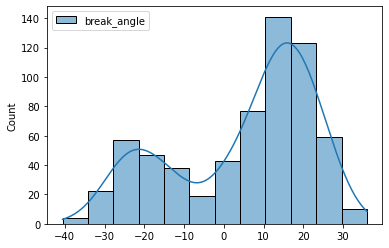

In [159]:
sns.histplot(data=average_break_angle_pitcher, kde=True)


<AxesSubplot:ylabel='Count'>

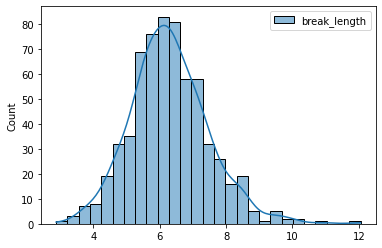

In [62]:
sns.histplot(data=average_break_length_pitcher, kde=True)


<AxesSubplot:ylabel='Count'>

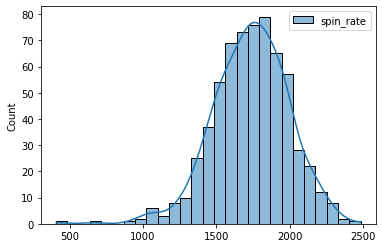

In [160]:
sns.histplot(data=average_spin_rate_pitcher, kde=True)


Merge them into a dataframe

In [161]:
avg_pitcher = average_start_speed_pitcher.merge(average_break_angle_pitcher, on='pitcher_id').merge(average_break_length_pitcher, on='pitcher_id').merge(average_spin_rate_pitcher, on='pitcher_id')

avg_pitcher.head()

,pitcher_id,start_speed,break_angle,break_length,spin_rate
0,110683,90.906579,16.340789,5.877303,1693.086941
1,112020,90.553995,19.617662,6.295122,1703.427424
2,112526,90.379049,26.035108,5.463986,1976.872403
3,115629,91.198268,25.294805,5.200433,1970.843797
4,115817,81.724933,15.808491,7.642588,1490.418241


In [162]:
avg_pitcher.describe()

,start_speed,break_angle,break_length,spin_rate
count,640.000000,640.000000,640.000000,640.000000
mean,88.226475,5.116203,6.302411,1735.779160
std,3.093908,17.603035,1.176640,257.218526
min,72.837500,-40.576712,2.880000,406.484500
25%,86.350539,-10.151520,5.542690,1571.760380
50%,88.448232,10.905414,6.237771,1743.180614
75%,90.292289,18.346604,7.013150,1910.282377
max,95.933198,36.023077,12.050000,2484.359890


Clustering the results - k means to find clusters amongst players

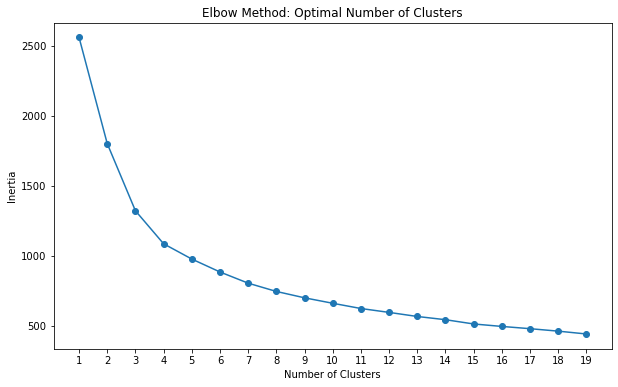

In [163]:
# This code uses the dataframe: avg_pitcher
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

avg_features = ['start_speed', 'break_angle', 'break_length', 'spin_rate']

# Prepare data for clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(avg_pitcher[avg_features])

inertia = []
k_range = range(1, 20)  # trying 3 to 10 clusters of pitchers

for k in k_range:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot Elbow curve to find optimal number of clusters 
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method: Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.show()


The Inertia seems to be decrease more slowly after 5 clusters. Let's select 5

Let's select 5 clusters:

In [271]:
# Pick optimal number of pitchers from plot above 
optimal_k = 5

# Cluster pitchers by their average values  
kmeans = KMeans(n_clusters = optimal_k)
avg_pitcher['cluster'] = kmeans.fit_predict(scaled_features)
kmeans.inertia_

975.9415697429129

In [272]:
avg_pitcher['cluster']

0      0
1      1
2      0
3      0
4      4
      ..
635    2
636    3
637    1
638    0
639    1
Name: cluster, Length: 640, dtype: int32

/Users/gregorycrooks/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='cluster', ylabel='Density'>

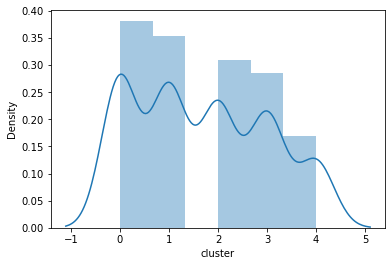

In [273]:
sns.distplot(avg_pitcher['cluster'])

Now let's insert that back into the dataframe:

In [274]:
df2 = df.copy()

df2 = df2.merge(avg_pitcher, on='pitcher_id')

rename_columns = {
    'start_speed_y': 'start_speed_average_pitcher',
    'break_angle_y': 'break_angle_average_pitcher',
    'break_length_y': 'break_length_average_pitcher',
    'spin_rate_y': 'spin_rate_average_pitcher'
}

# Rename the columns in the DataFrame
df2 = df2.rename(columns=rename_columns)


/Users/gregorycrooks/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='cluster', ylabel='Density'>

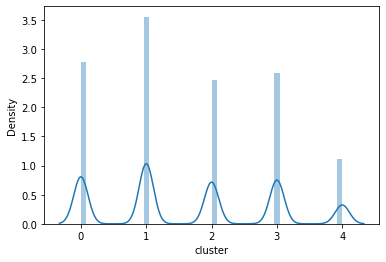

In [280]:
sns.distplot(df2["cluster"])

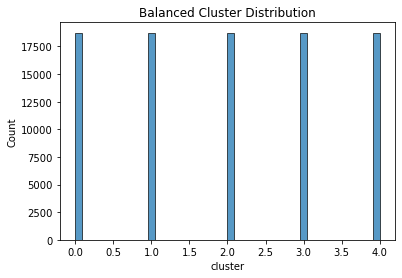

In [282]:
from sklearn.utils import resample
# Step 1: Determine the size of the smallest cluster
min_cluster_size = df2['cluster'].value_counts().min()

# Step 2: Group by 'cluster' and undersample each cluster to the size of the smallest cluster
df_balanced = df2.groupby('cluster').apply(lambda x: resample(x, n_samples=min_cluster_size, random_state=42)).reset_index(drop=True)

# Step 3: Plot the balanced distribution
sns.histplot(df_balanced["cluster"])
plt.title("Balanced Cluster Distribution")
plt.show()

In [149]:
avg_pitcher

,pitcher_id,start_speed,break_angle,break_length,spin_rate,cluster
0,110683,90.906579,16.340789,5.877303,1693.086941,1
1,112020,90.553995,19.617662,6.295122,1703.427424,4
2,112526,90.379049,26.035108,5.463986,1976.872403,1
3,115629,91.198268,25.294805,5.200433,1970.843797,1
4,115817,81.724933,15.808491,7.642588,1490.418241,3
...,...,...,...,...,...,...
635,572070,92.428723,10.084043,5.889362,1428.046457,0
636,573244,84.012500,-23.558929,5.905357,1988.791429,2
637,579799,87.741860,18.377326,7.179070,1713.676326,4
638,592665,90.916129,23.577419,4.319355,2127.286387,1


In [283]:
import plotly.graph_objects as go
import numpy as np

# Apply logarithmic transformation to the columns, handling non-positive values
avg_pitcher['log_start_speed'] = np.log(avg_pitcher['start_speed'].replace(0, np.nan))
avg_pitcher['log_break_angle'] = np.log(avg_pitcher['break_angle'].replace(0, np.nan))
avg_pitcher['log_break_length'] = np.log(avg_pitcher['break_length'].replace(0, np.nan))
avg_pitcher['log_spin_rate'] = np.log(avg_pitcher['spin_rate'].replace(0, np.nan))

# Create the box plots for the log-transformed values
fig = go.Figure()

# Boxplot for Logarithmic Start Speed
fig.add_trace(go.Box(y=avg_pitcher['log_start_speed'], name='Log Start Speed'))

# Boxplot for Logarithmic Break Angle
fig.add_trace(go.Box(y=avg_pitcher['log_break_angle'], name='Log Break Angle'))

# Boxplot for Logarithmic Break Length
fig.add_trace(go.Box(y=avg_pitcher['log_break_length'], name='Log Break Length'))

# Boxplot for Logarithmic Spin Rate
fig.add_trace(go.Box(y=avg_pitcher['log_spin_rate'], name='Log Spin Rate'))

# Update layout
fig.update_layout(
    title="Logarithmic Boxplots for Pitcher Metrics", 
    yaxis_title="Logarithmic Value",
    boxmode='group',  # Group the box plots
    width=800, 
    height=600
)

# Show the plot
fig.show()


/Users/gregorycrooks/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning:

invalid value encountered in log



In [195]:
df2.columns

Index(['uid', 'game_pk', 'team_id_b', 'team_id_p', 'inning', 'top',
       'at_bat_num', 'pcount_at_bat', 'pcount_pitcher', 'balls', 'strikes',
       'fouls', 'outs', 'is_final_pitch', 'final_balls', 'final_strikes',
       'final_outs', 'batter_id', 'stand', 'b_height', 'pitcher_id',
       'p_throws', 'at_bat_des', 'event', 'event2', 'event3', 'event4',
       'away_team_runs', 'home_team_runs', 'score', 'pitch_des', 'pitch_id',
       'type', 'pitch_tfs_zulu', 'x', 'y', 'sv_id', 'start_speed_x',
       'end_speed', 'sz_top', 'sz_bot', 'pfx_x', 'pfx_z', 'px', 'pz', 'x0',
       'z0', 'y0', 'vx0', 'vz0', 'vy0', 'ax', 'az', 'ay', 'break_length_x',
       'break_y', 'break_angle_x', 'pitch_type', 'type_confidence', 'zone',
       'nasty', 'spin_dir', 'spin_rate_x', 'on_1b', 'on_2b', 'on_3b',
       'start_speed_average_pitcher', 'break_angle_average_pitcher',
       'break_length_average_pitcher', 'spin_rate_average_pitcher', 'cluster',
       'start_speed_tier', 'break_angle_tier', 'b

square transf on Left skewed: start_speed_average_pitcher, break_angle_average_pitcher
log transformation on right skewed: break_length_average_pitcher,  spin_rate_average_pitcher

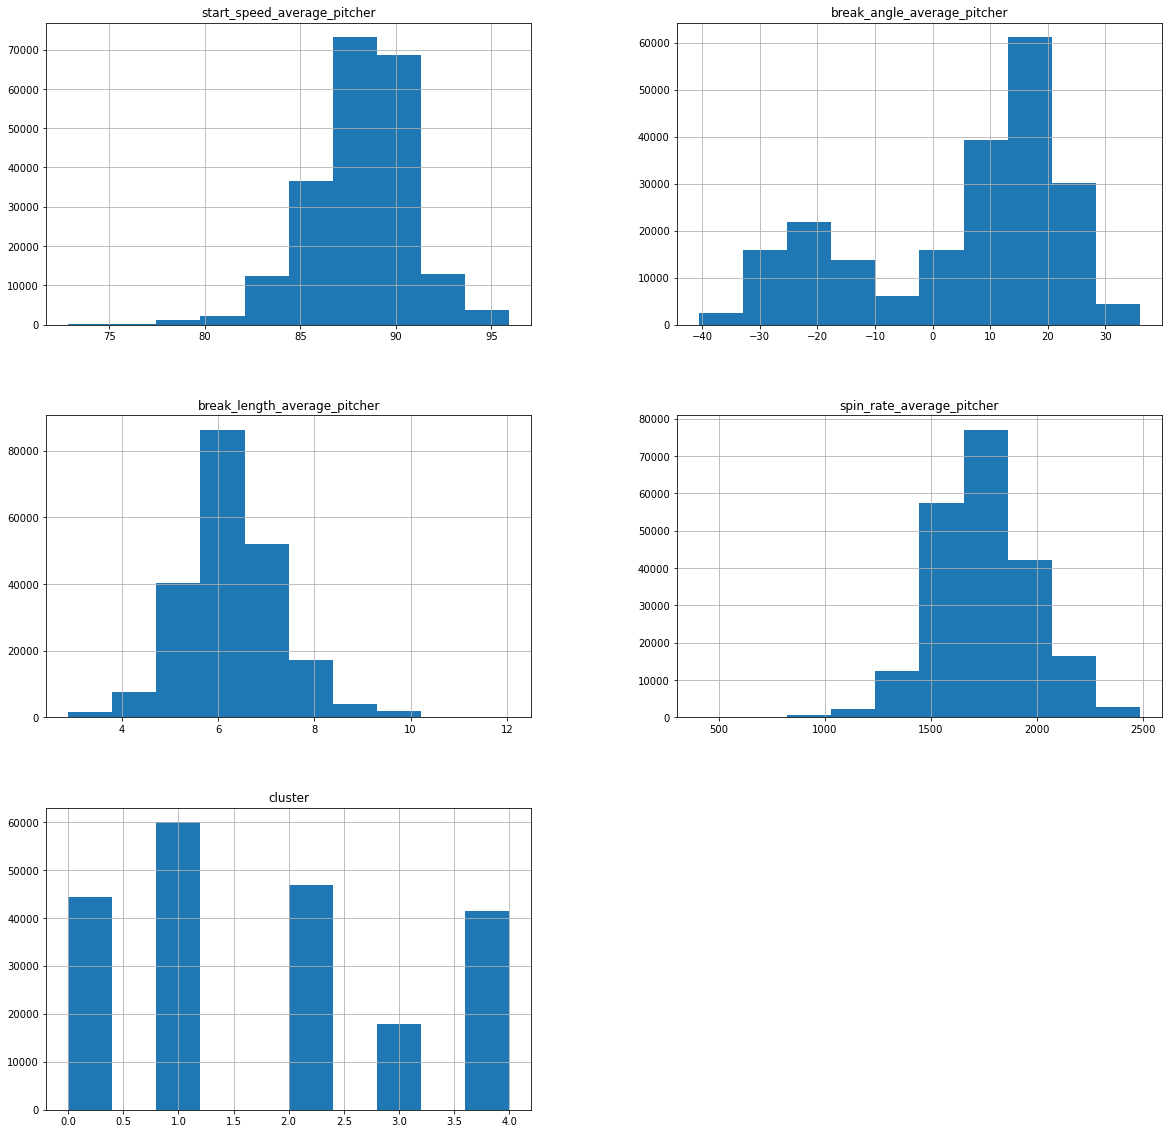

In [197]:
from matplotlib import pyplot
df2.loc[:,['start_speed_average_pitcher', 'break_angle_average_pitcher',
       'break_length_average_pitcher', 'spin_rate_average_pitcher']].hist(figsize=(20, 20))  # You can modify the (12, 10) to any size that fits your needs
pyplot.show()

In [284]:
import numpy as np

# Apply square transformation to left-skewed data and replace the original columns
df2['start_speed_average_pitcher'] = np.square(df2['start_speed_average_pitcher'])
df2['break_angle_average_pitcher'] = np.square(df2['break_angle_average_pitcher'])

# Apply log transformation to right-skewed data and replace the original columns
# Handling non-positive values by replacing them with NaN
df2['break_length_average_pitcher'] = np.log(df2['break_length_average_pitcher'].replace(0, np.nan))
df2['spin_rate_average_pitcher'] = np.log(df2['spin_rate_average_pitcher'].replace(0, np.nan))

# Display the updated DataFrame
df2[['start_speed_average_pitcher', 'break_angle_average_pitcher', 
     'break_length_average_pitcher', 'spin_rate_average_pitcher']]


,start_speed_average_pitcher,break_angle_average_pitcher,break_length_average_pitcher,spin_rate_average_pitcher
0,7877.726599,673.677854,1.708992,7.690182
1,7877.726599,673.677854,1.708992,7.690182
2,7877.726599,673.677854,1.708992,7.690182
3,7877.726599,673.677854,1.708992,7.690182
4,7877.726599,673.677854,1.708992,7.690182
...,...,...,...,...
210625,5772.200625,294.122500,2.256541,7.053371
210626,5772.200625,294.122500,2.256541,7.053371
210627,5772.200625,294.122500,2.256541,7.053371
210628,8262.810000,571.210000,1.504077,7.600454


Let's create categorical variables based on the average of these 5 variables, from very low to very high tier

In [285]:
import pandas as pd

# Function to calculate the boxplot-based tiers
def categorize_boxplot_tiers(series):
    # Calculate Q1, Q3, and IQR
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper fences
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR

    # Apply categorization based on the defined ranges
    conditions = [
        (series < lower_fence),                       # Very Low
        (series >= lower_fence) & (series < Q1),      # Low
        (series >= Q1) & (series <= Q3),              # Average
        (series > Q3) & (series <= upper_fence),      # High
        (series > upper_fence)                        # Very High
    ]

    # Tier labels
    tier_labels = ['Very Low', 'Low', 'Average', 'High', 'Very High']

    # Return categorized data
    return pd.cut(series, bins=[-float('inf'), lower_fence, Q1, Q3, upper_fence, float('inf')], labels=tier_labels)

# Apply the categorization to each of the relevant columns
df2['start_speed_tier'] = categorize_boxplot_tiers(df2['start_speed_average_pitcher'])
df2['break_angle_tier'] = categorize_boxplot_tiers(df2['break_angle_average_pitcher'])
df2['break_length_tier'] = categorize_boxplot_tiers(df2['break_length_average_pitcher'])
df2['spin_rate_tier'] = categorize_boxplot_tiers(df2['spin_rate_average_pitcher'])

# Display the updated DataFrame with the new tier columns
df2[['start_speed_average_pitcher', 'start_speed_tier',
     'break_angle_average_pitcher', 'break_angle_tier',
     'break_length_average_pitcher', 'break_length_tier',
     'spin_rate_average_pitcher', 'spin_rate_tier']]


,start_speed_average_pitcher,start_speed_tier,break_angle_average_pitcher,break_angle_tier,break_length_average_pitcher,break_length_tier,spin_rate_average_pitcher,spin_rate_tier
0,7877.726599,Average,673.677854,High,1.708992,Low,7.690182,High
1,7877.726599,Average,673.677854,High,1.708992,Low,7.690182,High
2,7877.726599,Average,673.677854,High,1.708992,Low,7.690182,High
3,7877.726599,Average,673.677854,High,1.708992,Low,7.690182,High
4,7877.726599,Average,673.677854,High,1.708992,Low,7.690182,High
...,...,...,...,...,...,...,...,...
210625,5772.200625,Very Low,294.122500,Average,2.256541,Very High,7.053371,Very Low
210626,5772.200625,Very Low,294.122500,Average,2.256541,Very High,7.053371,Very Low
210627,5772.200625,Very Low,294.122500,Average,2.256541,Very High,7.053371,Very Low
210628,8262.810000,High,571.210000,High,1.504077,Low,7.600454,High


In [300]:
# Downsample each tier to match the size of the smallest tier
def downsample_tiers(df, tier_column):
    # Determine the smallest tier size
    min_tier_size = df[tier_column].value_counts().min()

    # Group by the tier and downsample each tier to the size of the smallest tier
    df_balanced = df.groupby(tier_column).apply(lambda x: resample(x, n_samples=min_tier_size, random_state=42)).reset_index(drop=True)
    return df_balanced

# Downsample each tier for the relevant columns
df2_downsampled = downsample_tiers(df2, 'start_speed_tier')
df2_downsampled = downsample_tiers(df2, 'break_angle_tier')
df2_downsampled = downsample_tiers(df2, 'break_length_tier')
df2_downsampled = downsample_tiers(df2, 'spin_rate_tier')

# Display the updated DataFrame with the downsampled data
df2_downsampled[['start_speed_average_pitcher', 'start_speed_tier',
                 'break_angle_average_pitcher', 'break_angle_tier',
                 'break_length_average_pitcher', 'break_length_tier',
                 'spin_rate_average_pitcher', 'spin_rate_tier']]
df2_downsampled.spin_rate_tier.value_counts()

Very Low     73
Low          73
Average      73
High         73
Very High    73
Name: spin_rate_tier, dtype: int64

# Model 1: Simple Model

In [156]:
import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns

# Create a copy of the DataFrame
#df_new = df.copy()

# Define the pickle file path
pickle_file = '/Users/gregorycrooks/Downloads/pitches_folder/pitches.pkl'

# Check if the pickle file exists
if os.path.exists(pickle_file):
    print("Pickle file already exists at:", pickle_file)
    df = pd.read_pickle(pickle_file)
else:
    # Save the DataFrame to the pickle file if it doesn't exist
    with open(pickle_file, 'wb') as file:
        pickle.dump(df, file)
    print("DataFrame saved to pickle file at:", pickle_file)


Pickle file already exists at: /Users/gregorycrooks/Downloads/pitches_folder/pitches.pkl


In [287]:
df_new = df2.copy()
df_new

,uid,game_pk,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,...,spin_rate_average_pitcher,cluster,log_start_speed,log_break_angle,log_break_length,log_spin_rate,start_speed_tier,break_angle_tier,break_length_tier,spin_rate_tier
0,15083145,287308,121,143,5,1,34,1,71,0,...,7.690182,3,4.485897,NaN,1.708992,7.690182,Average,High,Low,High
1,19534982,289210,120,143,4,1,22,1,47,0,...,7.690182,3,4.485897,NaN,1.708992,7.690182,Average,High,Low,High
2,19535078,289210,120,143,7,1,51,2,118,1,...,7.690182,3,4.485897,NaN,1.708992,7.690182,Average,High,Low,High
3,18866380,288937,113,143,5,0,39,3,60,0,...,7.690182,3,4.485897,NaN,1.708992,7.690182,Average,High,Low,High
4,16901171,288088,111,143,1,1,2,1,3,0,...,7.690182,3,4.485897,NaN,1.708992,7.690182,Average,High,Low,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210625,15839408,287638,137,146,8,0,65,1,1,0,...,7.053371,4,4.330404,2.841998,2.256541,7.053371,Very Low,Average,Very High,Very Low
210626,17845137,288496,144,146,8,0,63,4,4,1,...,7.053371,4,4.330404,2.841998,2.256541,7.053371,Very Low,Average,Very High,Very Low
210627,15839409,287638,137,146,8,0,65,2,2,1,...,7.053371,4,4.330404,2.841998,2.256541,7.053371,Very Low,Average,Very High,Very Low
210628,19502110,289198,110,111,9,1,80,2,2,0,...,7.600454,0,4.509760,3.173878,1.504077,7.600454,High,High,Low,High


Creating a new feature: 2 or more players might be on a base at a time. This might interfer with the pitcher's ability to pitch, or even yet involve a tendency towards a certain pitch type. We create a binary variable to see if 2 players on a base at the same time

In [288]:
# Function to create a binary variable for having exactly two IDs
def two_players(row):
    # Count the non-null values in the 'on_1b', 'on_2b', 'on_3b' columns
    count_non_null = sum(pd.notnull([row['on_1b'], row['on_2b'], row['on_3b']]))
    return 'Yes' if count_non_null >= 2 else 'No'

# Apply the function to each row and create a new column 'two_players'
df_new['two_plus_players_base'] = df_new.apply(two_players, axis=1)
# We remove them since our new features provides more interpretable information
df_new = df_new.drop(columns=['on_1b', 'on_2b', 'on_3b'])

df_new['two_plus_players_base'].head()

0    No
1    No
2    No
3    No
4    No
Name: two_plus_players_base, dtype: object

Let's select features which, we found significant: Break Length, Break Angle, and Start Speed

In [289]:
df_new = df_new.loc[:,['cluster', 'pitch_type', 'start_speed_tier', 'break_angle_tier', 'break_length_tier', 'spin_rate_tier', 'two_plus_players_base']]

Let's solve the class imbalance - we find classes with at least 6000 observations and downsample all classes to the Min

In [290]:
pitch_counts = df['pitch_type'].value_counts()

# Step 1: Remove classes with fewer than 3000 observations
filtered_pitch_types = pitch_counts[pitch_counts >= 20000].index
df_filtered = df_new[df_new['pitch_type'].isin(filtered_pitch_types)]

# Step 2: Downsample the majority classes to match the size of the smallest class
min_count = pitch_counts[pitch_counts >= 20000].min()

# Resample each class to have the same number of observations as the minimum class
df_balanced = df_filtered.groupby('pitch_type').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)

df_new = df_balanced
# Display the new pitch type distribution
print(df_balanced['pitch_type'].value_counts())


Changeup              24225
Four-Seam Fastball    24225
Sinker                24225
Slider                24225
Two-Seam Fastball     24225
Name: pitch_type, dtype: int64


Let's see what type of transformation might be needed -Break Length is right skewed so we use Log transformation, and we use square transform for start_speed and break angle

In [ ]:
from matplotlib import pyplot
df_new.hist(figsize=(20, 20))  # You can modify the (12, 10) to any size that fits your needs
pyplot.show()

Removing pitch type-specific outliers for pre-processing:


# Function to remove outliers based on the IQR
def remove_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

# Applying the outlier removal function to each pitch type
cleaned_df = pd.DataFrame()  # Empty DataFrame to store results

for pitch_type in df_new['pitch_type'].unique():
    # Filter the DataFrame by pitch type
    subset = df_new[df_new['pitch_type'] == pitch_type]
    
    # Remove outliers for each feature within the pitch type
    for feature in ['start_speed', 'break_angle', 'break_length']:
        subset = remove_outliers(subset, feature)
    
    # Append cleaned data of current pitch type to the main DataFrame
    cleaned_df = pd.concat([cleaned_df, subset], ignore_index=True)

Transformation:

# Apply log transformation 
df_new['break_length'] = np.log(df_new['break_length'] + 1)

# Apply square transformation 
df_new['start_speed'] = df_new['start_speed'] ** 2
df_new['break_angle'] = df_new['break_angle'] ** 2

df_new.hist(figsize=(20, 20))  # You can modify the (12, 10) to any size that fits your needs
pyplot.show()

Normalizaling Data:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Assume the features to scale are still 'start_speed', 'break_angle', 'break_length'
features_to_scale = ['start_speed', 'break_angle', 'break_length']

# Fit and transform these features
cleaned_df[features_to_scale] = scaler.fit_transform(cleaned_df[features_to_scale])


Separate training and testing set:

In [291]:
df_new.columns

Index(['cluster', 'pitch_type', 'start_speed_tier', 'break_angle_tier',
       'break_length_tier', 'spin_rate_tier', 'two_plus_players_base'],
      dtype='object')

In [292]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 1. Prepare data
# 'pitch_type' will be the target variable (y), and the rest will be the features (X)
X = df_new.drop(columns=['pitch_type']).loc[:,['cluster', 'start_speed_tier', 'break_angle_tier',
       'break_length_tier', 'spin_rate_tier', 'two_plus_players_base']] # All features except the target
y = df_new['pitch_type']  # Target variable
X.dtypes

cluster                     int32
start_speed_tier         category
break_angle_tier         category
break_length_tier        category
spin_rate_tier           category
two_plus_players_base      object
dtype: object

In [293]:
X_categorical = X.select_dtypes(include=['object', 'category'])
X_numerical = X.select_dtypes(include=['int', 'float'])
dummies = pd.get_dummies(X_categorical)
merged = pd.concat([X_numerical,dummies],axis=1)
X = merged
X

,cluster,start_speed_tier_Very Low,start_speed_tier_Low,start_speed_tier_Average,start_speed_tier_High,start_speed_tier_Very High,break_angle_tier_Very Low,break_angle_tier_Low,break_angle_tier_Average,break_angle_tier_High,...,break_length_tier_Average,break_length_tier_High,break_length_tier_Very High,spin_rate_tier_Very Low,spin_rate_tier_Low,spin_rate_tier_Average,spin_rate_tier_High,spin_rate_tier_Very High,two_plus_players_base_No,two_plus_players_base_Yes
0,4,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0
1,4,0,1,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
2,4,0,1,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,1
3,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
4,3,0,0,1,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121120,2,0,0,1,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,1,0
121121,3,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
121122,2,0,0,1,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
121123,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1


Hot One Encode Target Variable:

In [294]:
from sklearn.preprocessing import OneHotEncoder
# One-hot encode the target variable
encoder = OneHotEncoder(sparse=False)
y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))

Fit the Multinomial Logistic Regression Model

In [295]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded.argmax(axis=1), test_size=0.2, random_state=42)

# Create and fit the logistic regression model (assuming a multinomial case since it's categorical)
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

The model seems performs well, with a 63% accuracy

In [296]:
# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate a classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.35
              precision    recall  f1-score   support

           0       0.35      0.21      0.26      4907
           1       0.35      0.35      0.35      4899
           2       0.35      0.66      0.45      4902
           3       0.36      0.27      0.31      4777
           4       0.32      0.24      0.27      4740

    accuracy                           0.35     24225
   macro avg       0.35      0.34      0.33     24225
weighted avg       0.35      0.35      0.33     24225



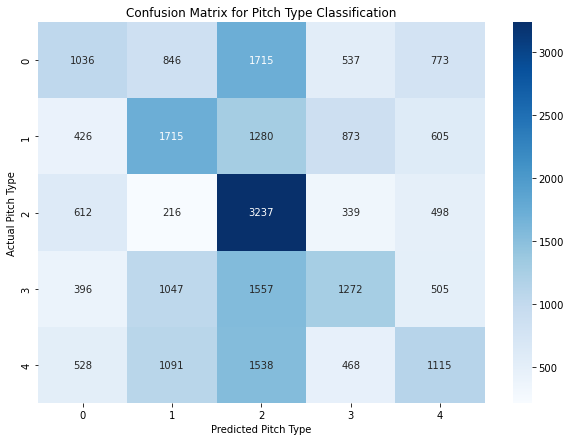

In [297]:
from sklearn.metrics import confusion_matrix
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the unique pitch types to label the confusion matrix
pitch_types = model.classes_  # This will give the pitch type names in the order of the labels

# Convert confusion matrix to a DataFrame for better readability
cm_df = pd.DataFrame(cm, index=pitch_types, columns=pitch_types)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')  # fmt='g' ensures integer formatting
plt.title('Confusion Matrix for Pitch Type Classification')
plt.ylabel('Actual Pitch Type')
plt.xlabel('Predicted Pitch Type')
plt.show()

# Model 2: More Complex Model

Copy df

In [ ]:
df_new = df.copy()

We drop columns with little significance and collinearity issues:

In [ ]:
df_new = df_new.drop(columns=['end_speed', 'sz_top', 'sz_bot', 'is_final_pitch', 'top', 'vy0','stand', 'p_throws', 'score', 'stand','pitch_tfs_zulu'])

Creating a new feature: 2 or more players might be on a base at a time. This might interfer with the pitcher's ability to pitch, or even yet involve a tendency towards a certain pitch type. We create a binary variable to see if 2 players on a base at the same time

In [ ]:
# Function to create a binary variable for having exactly two IDs
def two_players(row):
    # Count the non-null values in the 'on_1b', 'on_2b', 'on_3b' columns
    count_non_null = sum(pd.notnull([row['on_1b'], row['on_2b'], row['on_3b']]))
    return 'Yes' if count_non_null >= 2 else 'No'

# Apply the function to each row and create a new column 'two_players'
df_new['two_plus_players_base'] = df_new.apply(two_players, axis=1)
# We remove them since our new features provides more interpretable information
df_new = df_new.drop(columns=['on_1b', 'on_2b', 'on_3b'])

df_new['two_plus_players_base'].head()

<b>Pre-Processing Numerical Values

Removing Outliers - Preventing bias in Standardization. Looking at the previous boxplot for start speed, Four Seam, and Two Seam Fastballs both have many outliers. Same goes for the Break Angle, and Cutter feature with the Sinker pitch type. Let's remove the

In [ ]:
# Define pitch types and variables to filter
outlier_specs = {
    'Four Seam Fastball': ['start_speed'],
    'Two Seam Fastball': ['start_speed'],
    'Cutter': ['break_angle'],
    'Sinker': ['break_angle']
}

# Apply the outlier removal function based on outlier_specs
cleaned_df = pd.DataFrame()  # Empty DataFrame to store results

# Loop over the defined pitch types and features in the outlier_specs
for pitch_type, features in outlier_specs.items():
    # Filter the DataFrame by pitch type
    subset = df_new[df_new['pitch_type'] == pitch_type]
    
    # Remove outliers for each feature within the pitch type
    for feature in features:
        subset = remove_outliers(subset, feature)
    
    # Append cleaned data for the current pitch type to the main DataFrame
    cleaned_df = pd.concat([cleaned_df, subset], ignore_index=True)

# For all other pitch types, append without outlier removal
for pitch_type in df_new['pitch_type'].unique():
    if pitch_type not in outlier_specs:
        # Just append the data without removing outliers
        subset = df_new[df_new['pitch_type'] == pitch_type]
        cleaned_df = pd.concat([cleaned_df, subset], ignore_index=True)

# Display the cleaned DataFrame
df_new = cleaned_df

Transformation - We earlier use log transformationWe find the following the following skewness:
- Righ Skew: pcount pitcher, inning, break length, home teamn runs, at_bat_num
- Left Skew:pfx_z, start_speed, break_angle, spin_rate, spin_dir, az

In [ ]:
from matplotlib import pyplot
df_new.hist(figsize=(20, 20))  # You can modify the (12, 10) to any size that fits your needs
pyplot.show()

Let's transform columns based on skewdness, log transformation for right skew, and square transf for left skew

- Righ Skew: pcount pitcher, inning, break length, home teamn runs, at_bat_num
- Left Skew:pfx_z, start_speed, break_angle, spin_rate, spin_dir, az

In [ ]:
df_new2 = df_new.copy()

The normalization seems to work very well on az, and break length

In [ ]:

# Define columns that are right-skewed and left-skewed
right_skew_columns = ['pcount_pitcher', 'inning', 'break_length', 'home_team_runs', 'at_bat_num']
left_skew_columns = ['pfx_z', 'start_speed', 'break_angle', 'spin_rate', 'spin_dir', 'az']

# Log transformation for right-skewed columns (handle zero or negative values by adding a small constant)
for col in right_skew_columns:
    # Ensure the column has no zero or negative values (log(0) is undefined)
    df_new2[col] = np.log(df_new2[col] + 1)  # Adding 1 to avoid log(0) issues

# Cube transformation for left-skewed columns
for col in left_skew_columns:
    df_new2[col] = np.cbrt(df_new2[col])

# Plot histograms for all columns in df_new
df_new2[right_skew_columns + left_skew_columns].hist(figsize=(20, 20))  # Modify the size as needed

# Now, remove all other numerical columns except the transformed ones
# Get a list of all numerical columns
numerical_columns = df_new2.select_dtypes(include=[np.number]).columns.tolist()

# Create a list of the transformed columns
transformed_columns = right_skew_columns + left_skew_columns

cat_columns = df_new2.select_dtypes(include=['object']).columns.tolist()

# Drop all numerical columns except the transformed ones
columns_to_keep = transformed_columns + cat_columns + ['pitch_type']  # Keeping the pitch_type or any other categorical columns you need
df_new2 = df_new2[columns_to_keep]
plt.tight_layout()  # Adjusts the spacing between plots for better visualization
plt.show()


Let's scale these features:

In [ ]:
features_to_scale = transformed_columns 

df_new2[features_to_scale] = scaler.fit_transform(df_new2[features_to_scale])


In [ ]:
df_new2[features_to_scale].isna().sum()

Let's remove columns with NAs

In [ ]:
df_new2 = df_new2.drop(columns=["home_team_runs"])

<b>Categorical data</b> - let's retain type, pitch_des, and the two_plus_players_base columns

In [ ]:
df_new3 = df_new2.copy()
df_new3 = df_new3.loc[:, ~df_new3.columns.duplicated()]

In [ ]:

# Define the categorical columns to retain
selected_categorical_columns = ['pitch_type', 'type', 'pitch_des', 'two_plus_players_base']

# Select only the specified categorical columns
df_selected_categorical = df_new3[selected_categorical_columns]

# Select the numerical columns, making sure to exclude 'pitch_type' to avoid duplicates
numerical_columns = df_new3.drop(columns=['pitch_type']).select_dtypes(include=['int', 'float'])

# Concatenate the numerical columns and the selected categorical columns
df_new3_clean = pd.concat([numerical_columns, df_selected_categorical], axis=1)

# Remove duplicate rows if needed, but it might not be necessary
# Display the first few rows of the cleaned DataFrame
#df_new3_clean = df_new3_clean.drop(df_new3_clean.columns[11], axis=1)

df_new3_clean

Separate target variable - train test split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 1. Prepare data
# 'pitch_type' will be the target variable (y), and the rest will be the features (X)
X = df_new3_clean.drop(columns=['pitch_type']) # All features except the target
y = df_new3_clean['pitch_type']  # Target variable

Dealing with imbalance for the target variable

In [ ]:
# Combine X and y, filter pitch types with >= 7000 observations, and downsample
df_filtered = pd.concat([X, y], axis=1)
valid_pitch_types = df_filtered['pitch_type'].value_counts().loc[lambda x: x >= 20000]
min_count = valid_pitch_types.min()
df_filtered = df_filtered[df_filtered['pitch_type'].isin(valid_pitch_types.index)]

# Downsample each pitch type to the minimum count
df_downsampled = df_filtered.groupby('pitch_type').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)

# Separate back into X and y
X, y = df_downsampled.drop(columns=['pitch_type']), df_downsampled['pitch_type']

# Display class distribution
print(y.value_counts())


In [ ]:
y.values.shape

Categorical encoding - Explanatory Variables

In [ ]:
X_categorical = X.select_dtypes(include=['object'])
X_numerical = X.select_dtypes(include=['int', 'float'])
dummies = pd.get_dummies(X_categorical)
merged = pd.concat([X_numerical,dummies],axis=1)
X = merged
X

Categorical encoding - Target Variable

In [ ]:
dummies = pd.get_dummies(y)
y = dummies
y

Let's save it:

In [ ]:
X_processed = X.copy()
y_processed = y.copy()

y_processed = y_processed.values
y_processed.shape

Do the train-test split

In [ ]:
X_processed.isnull().sum()

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed.argmax(axis=1), test_size=0.2, random_state=42)
# Create and fit the logistic regression model (assuming a multinomial case since it's categorical)
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

Predicting the model - we find a 75% accuracy

In [ ]:
# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate a classification report
print(classification_report(y_test, y_pred))

The model performs well when adding other numerical and categorical variables !

In [ ]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the unique pitch types to label the confusion matrix
pitch_types = model.classes_  # This will give the pitch type names in the order of the labels

# Convert confusion matrix to a DataFrame for better readability
cm_df = pd.DataFrame(cm, index=pitch_types, columns=pitch_types)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')  # fmt='g' ensures integer formatting
plt.title('Confusion Matrix for Pitch Type Classification')
plt.ylabel('Actual Pitch Type')
plt.xlabel('Predicted Pitch Type')
plt.show()

# Other

Let's save these two to the data:

In [ ]:
# Apply log transformation for the 'break_length' column (right-skewed)
df_new2['break_length'] = np.log(df_new2['break_length'] + 1)  # Adding 1 to avoid log(0) issues

# Apply cube root transformation for the 'az' column (left-skewed)
df_new2['az'] = np.cbrt(df_new2['az'])

Reciprocal transformation seems to be effective in making the distribution normal

In [ ]:
# Define columns that are right-skewed and left-skewed
right_skew_columns = ['pcount_pitcher', 'inning', 'home_team_runs', 'at_bat_num']
left_skew_columns = ['pfx_z', 'start_speed', 'break_angle', 'spin_rate', 'spin_dir']

# Square Root Transformation for right-skewed columns (other than 'break_length' already transformed)
for col in right_skew_columns:
    df_new2[col + '_sqrt'] = np.sqrt(df_new2[col])

# Reciprocal Transformation for left-skewed columns (other than 'az' already transformed)
for col in left_skew_columns:
    df_new2[col + '_reciprocal'] = 1 / (df_new2[col] + 1)  # Adding 1 to avoid division by zero

# Plot histograms for all columns in df_new
df_new2[right_skew_columns + left_skew_columns].hist(figsize=(20, 20))  # Modify the size as needed
plt.tight_layout()  # Adjusts the spacing between plots for better visualization
plt.show()


Saving reciprocal transformed columns:

In [ ]:

# Define left-skewed columns
left_skew_columns = ['pfx_z', 'start_speed', 'break_angle', 'spin_rate', 'spin_dir']

# Apply Reciprocal Transformation for left-skewed columns
for col in left_skew_columns:
    df_new2[col] = 1 / (df_new2[col] + 1)  # Adding 1 to avoid division by zero


Let's see if we can find other transformations for the right skewed columns:

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats

# Define right-skewed columns
right_skew_columns = ['pcount_pitcher', 'inning', 'home_team_runs', 'at_bat_num']

# Assuming df_new2 is a copy of the original dataframe
df_new2 = df.copy()

# Apply Square Root Transformation for right-skewed columns
for col in right_skew_columns:
    df_new2[col + '_sqrt'] = np.sqrt(df_new2[col])

# Apply Box-Cox Transformation (only works for positive values)
for col in right_skew_columns:
    # Ensure no zero or negative values before applying Box-Cox
    df_new2[col + '_boxcox'], _ = stats.boxcox(df_new2[col] + 1)  # Adding 1 to avoid log(0) issues

# Apply Yeo-Johnson Transformation (can handle negative and zero values)
for col in right_skew_columns:
    df_new2[col + '_yeojohnson'], _ = stats.yeojohnson(df_new2[col])

# Plot histograms to visualize the transformations
import matplotlib.pyplot as plt

# List of transformed columns to plot
transformed_columns = [col + '_sqrt' for col in right_skew_columns] + \
                      [col + '_boxcox' for col in right_skew_columns] + \
                      [col + '_yeojohnson' for col in right_skew_columns]

# Create histograms for the transformed columns
df_new2[transformed_columns].hist(figsize=(20, 20))
plt.tight_layout()
plt.show()

# pcount pitcher sqrt, inning sqrt, at bat num yeojohnson


Let's apply additional transformations:

In [ ]:
# Apply Square Root Transformation for 'pcount_pitcher' and 'inning'
df_new2['pcount_pitcher'] = np.sqrt(df_new2['pcount_pitcher'])
df_new2['inning'] = np.sqrt(df_new2['inning'])

# Apply Yeo-Johnson Transformation for 'at_bat_num'
df_new2['at_bat_num'], _ = stats.yeojohnson(df_new2['at_bat_num'])

# Optionally, you can check the transformed data
print(df_new2[['pcount_pitcher', 'inning', 'at_bat_num_']].head())

Let's apply a Standard Scaler: 

In [ ]:
df_new3 = df_new2.copy()

In [ ]:
# 1. Prepare data: 'pitch_type' will be the target variable (y), and the rest will be the features (X)
X = df_new3.drop(columns=['pitch_type'])  # All features except the target
y = df_new3['pitch_type']  # Target variable

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 3. Apply StandardScaler to the training data (fit on train, transform on both train and test)
scaler = StandardScaler()

# Fit on training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data using the same scaler
X_test_scaled = scaler.transform(X_test)

Scaling values:

In [ ]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
scaledX = scale.fit_transform(df_new3.select_dtypes(include=['int', 'float']))
print(scaledX)

In [ ]:
# 1. Select and one-hot encode the categorical columns
selected_columns = ['pitch_type', 'pitch_des', 'pitch_id', 'two_plus_players_base', 'type']
df_encoded = pd.get_dummies(df_new3[selected_columns])

# 2. Select the numeric columns and apply standard scaling
numerics = df_new3.select_dtypes(include=['int', 'float'])
scale = StandardScaler()
scaled_numeric = scale.fit_transform(numerics)

# Convert scaled numeric data back to a DataFrame with appropriate column names
df_scaled_numeric = pd.DataFrame(scaled_numeric, columns=numerics.columns, index=df_new3.index)

# 3. Concatenate the scaled numeric data and one-hot encoded categorical data
df_final = pd.concat([df_scaled_numeric, df_encoded], axis=1)

# Display the first few rows of the final DataFrame
df_final

Selecting a subset of categorical variables to encode:

In [ ]:
# Assuming df_new3 is your DataFrame, select only the specified categorical columns
selected_columns = ['pitch_type', 'pitch_des', 'two_plus_players_base', 'type']

# Filter the DataFrame to include only these columns
df_selected = df_new3[selected_columns]

# Apply One-Hot Encoding using pandas get_dummies
df_encoded = pd.get_dummies(df_selected, columns=selected_columns)

Standardizing Data - Data imbalance

Look at the histograms for these features

0. Remove Outliers if necesary - like in fastball in the speed boxplot (top 5% outlier)
1. Figure out transformation to apply
2. Apply a scaler to numerical features
3. One hot encoding categorical features

Do a transformation, standardization, and then take the one hot encoding for cat
Create a function to check the skew of the mean. Check how much bigger the mean is from the median

Transformation - numeric columns and look at the histograms; log transformation if right skew (mean bigger than median), left skew: square transf or exponential exp (feature) 

Lasso  - bends linear regression by adjusting trajectory of the best fit

In [ ]:
df_new = df.copy()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Lasso

encoder = OneHotEncoder()
df_pitch_type = encoder.fit_transform(df_new[["pitch_type"]]).toarray()
encoded_df = pd.DataFrame(df_pitch_type, columns=encoder.get_feature_names_out(["pitch_type"]))
df_encoded = pd.concat([df, encoded_df], axis=1)
df_encoded

Let's remove the NAs to fit the lasso

In [ ]:
# Step 1: Drop all the rows where pitch type is not one of the values matching the MLB standards
# Step 2: Filter out for the rows that don't make sense, group data based on the different uniqeu values on pitch, and do EDA based on pitch
# pitch type values
# Histogram of start_speed when == FF or CH
# need to know which variables are useful to predict pitch type
# Reverse engineerting to know which feature would be the i
# Separate data on pitch type
df[df['pitch_type']

Some values are distributed across the data. Need to have a model predicting 14 different things

Instead of the mean

Find a pitch type with different distribution than data has on average

Numeric features: can look at mean or median

Histogram of feature 2, and now overlay the histogram with FF vs CH.

Reverse engineering